In [1]:
!pip install split-folders

In [2]:
!pip install tensorflow

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import random as r
sns.set_style("whitegrid")

# Modules used for suppressing warnings
import warnings 
warnings.filterwarnings('ignore')

# Modules used for dataset split
import splitfolders
import os

# Modules used for model training and transfer learning
import tensorflow as tf
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import Model

In [7]:
# Centering all the output images in the notebook.
from IPython.core.display import HTML as Center

Center(""" <style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style> """)

In [8]:
class Dataset:

    def __init__(self, dataset_path : str):
        self.PARENT = dataset_path
        self.class_distribution = dict()
    
    def __compute_class_distributions(self):
        for dirname in os.listdir(self.PARENT):
            self.class_distribution[dirname] = len(os.listdir(os.path.join(self.PARENT, dirname)))

    def class_distributions(self):
        self.__compute_class_distributions()

        plt.figure(figsize=(10,10))
        plt.bar(self.class_distribution.keys(),
        self.class_distribution.values(),
        color=["crimson","red","orange","yellow"])
        plt.xticks(rotation=90)
        plt.title("Class Distribution of PlantVillage dataset")
        plt.xlabel("Class Label")
        plt.ylabel("Frequency of class")
        plt.show()

    def show_class_samples(self):
        rows = 5
        columns = 3
        c = 0
        fig, axs = plt.subplots(rows, columns,figsize=(15,15))
        for dirname in os.listdir(self.PARENT):
            img_path = r.choice(os.listdir(os.path.join(self.PARENT, dirname)))
            image = mpimg.imread(os.path.join(self.PARENT, dirname, img_path))
            axs[c//columns, c%columns].imshow(image)
            axs[c//columns, c%columns].set_title(dirname)
            c += 1
        fig.suptitle("Image Samples of Plant Village dataset")
        plt.subplots_adjust(bottom=0.1, top=0.9, hspace=0.5)
        plt.show()

In [9]:
plant_village = Dataset("PlantVillage")

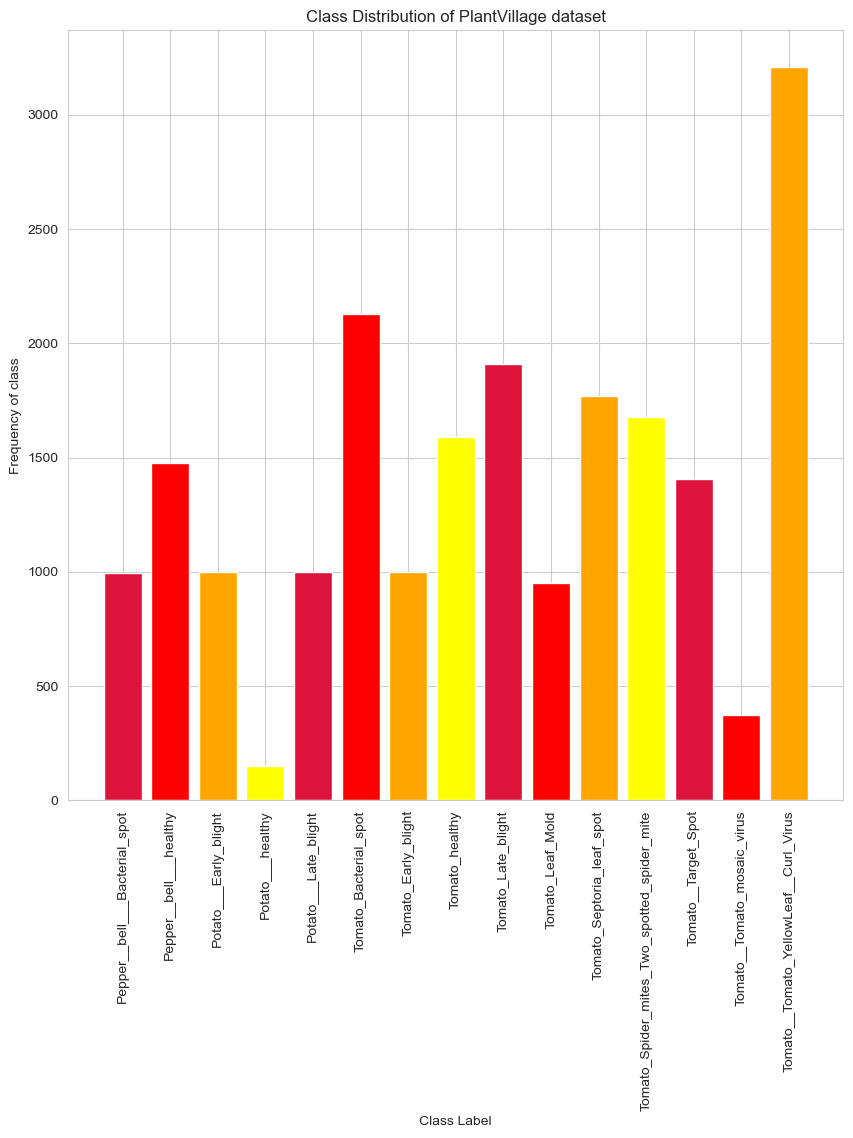

In [10]:
plant_village.class_distributions()

# Sample Images

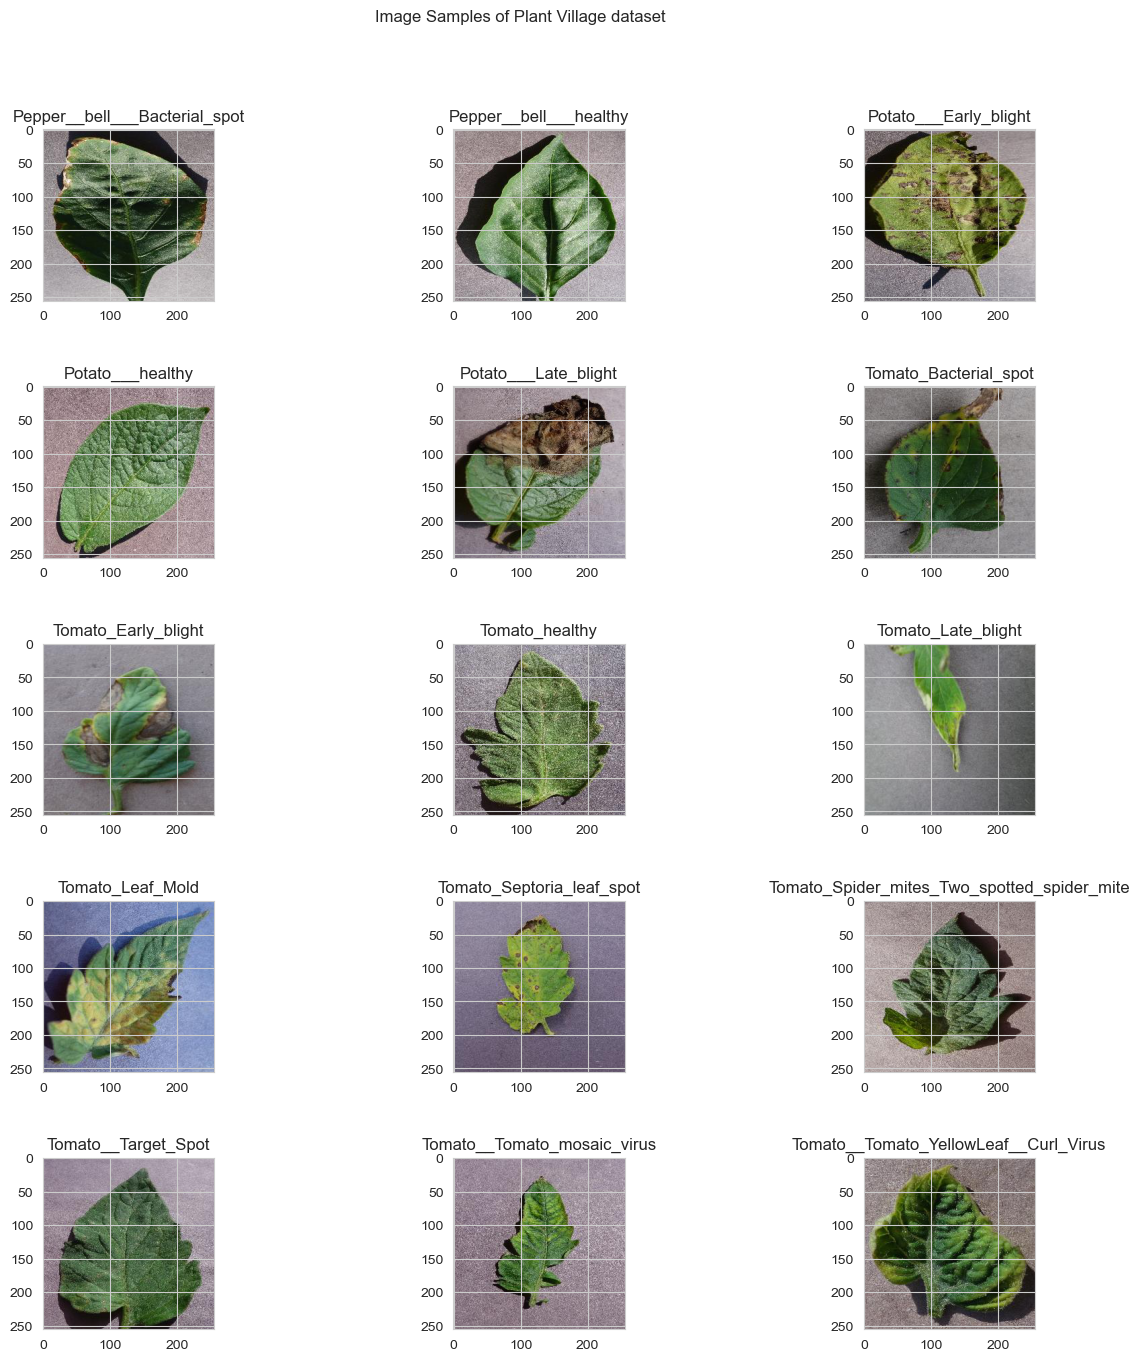

In [11]:
plant_village.show_class_samples()

# Splitting of Data

In [12]:
class DataSplit:

    def __init__(self, dataset_path : str, destination_path : str, train : float, test : float, val : float) -> None:
        self.PARENT = dataset_path
        self.TRAIN = train
        self.TEST = test
        self.VAL = val
        self.destination_path = destination_path
        self.train_gen = None
        self.test_gen = None
        self.val_gen = None
        self.TRAIN_DIR = "dataset/train"
        self.TEST_DIR = "dataset/test"
        self.VAL_DIR = "dataset/val"

    def test_train_validation_split(self):
        assert (self.TRAIN + self.TEST + self.VAL) == 1

        splitfolders.ratio(input = self.PARENT, 
                           output = self.destination_path,
                           seed = 1337, ratio = (.8, .1, .1), 
                           group_prefix = None, 
                           move = False)

    def create_generators(self):
        self.train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
            preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
        )

        self.test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
            preprocessing_function=tf.keras.applications.resnet50.preprocess_input
        )

        self.val_gen =  tf.keras.preprocessing.image.ImageDataGenerator(
            preprocessing_function=tf.keras.applications.resnet50.preprocess_input
        )

    def get_images(self):
        train_images = self.train_gen.flow_from_directory(
            directory=self.TRAIN_DIR,
            target_size=(75, 75),
            color_mode='rgb',
            class_mode='categorical',
            batch_size=32,
            shuffle=True,
            seed=42,
            subset='training'
        )

        val_images = self.val_gen.flow_from_directory(
            directory=self.VAL_DIR,
            target_size=(75, 75),
            color_mode='rgb',
            class_mode='categorical',
            batch_size=32,
            shuffle=True,
            seed=42
        )

        test_images = self.test_gen.flow_from_directory(
            directory=self.TEST_DIR,
            target_size=(75, 75),
            color_mode='rgb',
            class_mode='categorical',
            batch_size=32,
            shuffle=False,
            seed=42
        )

        return train_images, val_images, test_images

In [13]:
ds = DataSplit("PlantVillage","dataset",0.8,0.1, 0.1)

In [14]:
ds.test_train_validation_split()

Copying files: 20639 files [02:58, 115.92 files/s]


In [15]:
train = Dataset("dataset/train/")

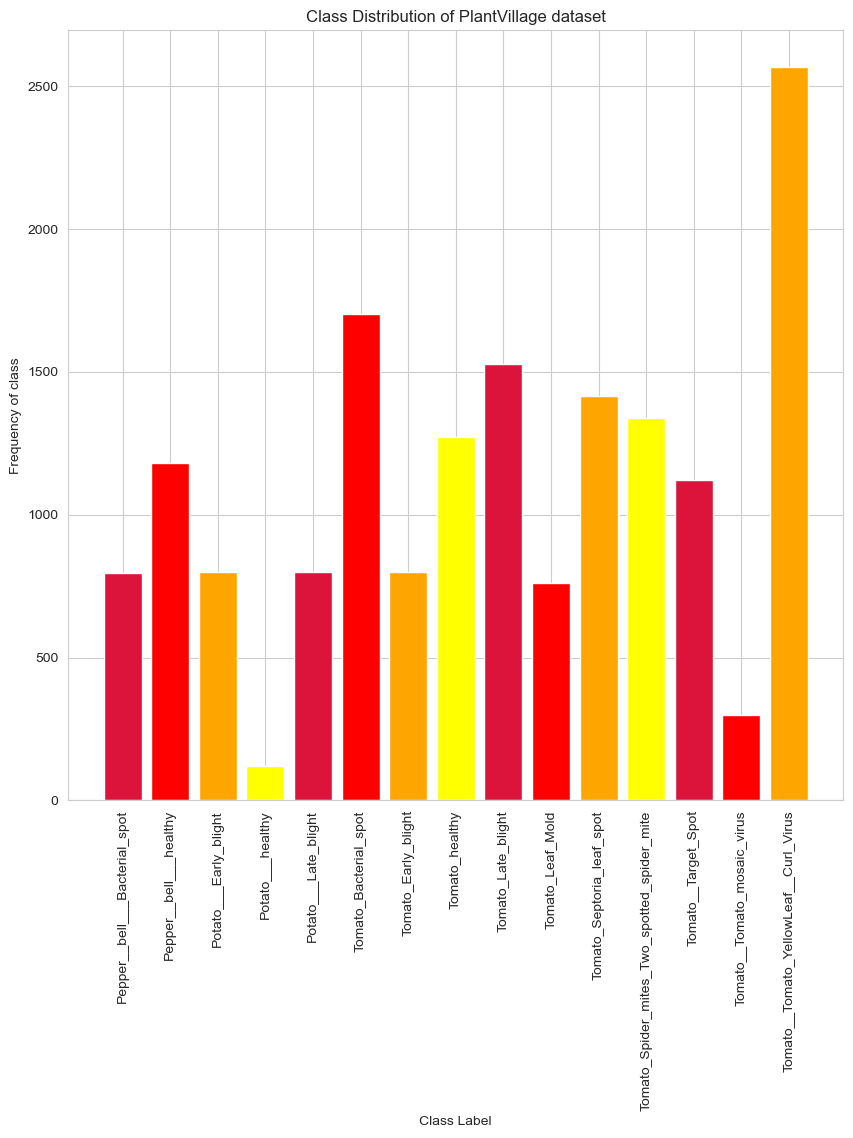

In [16]:
train.class_distributions()

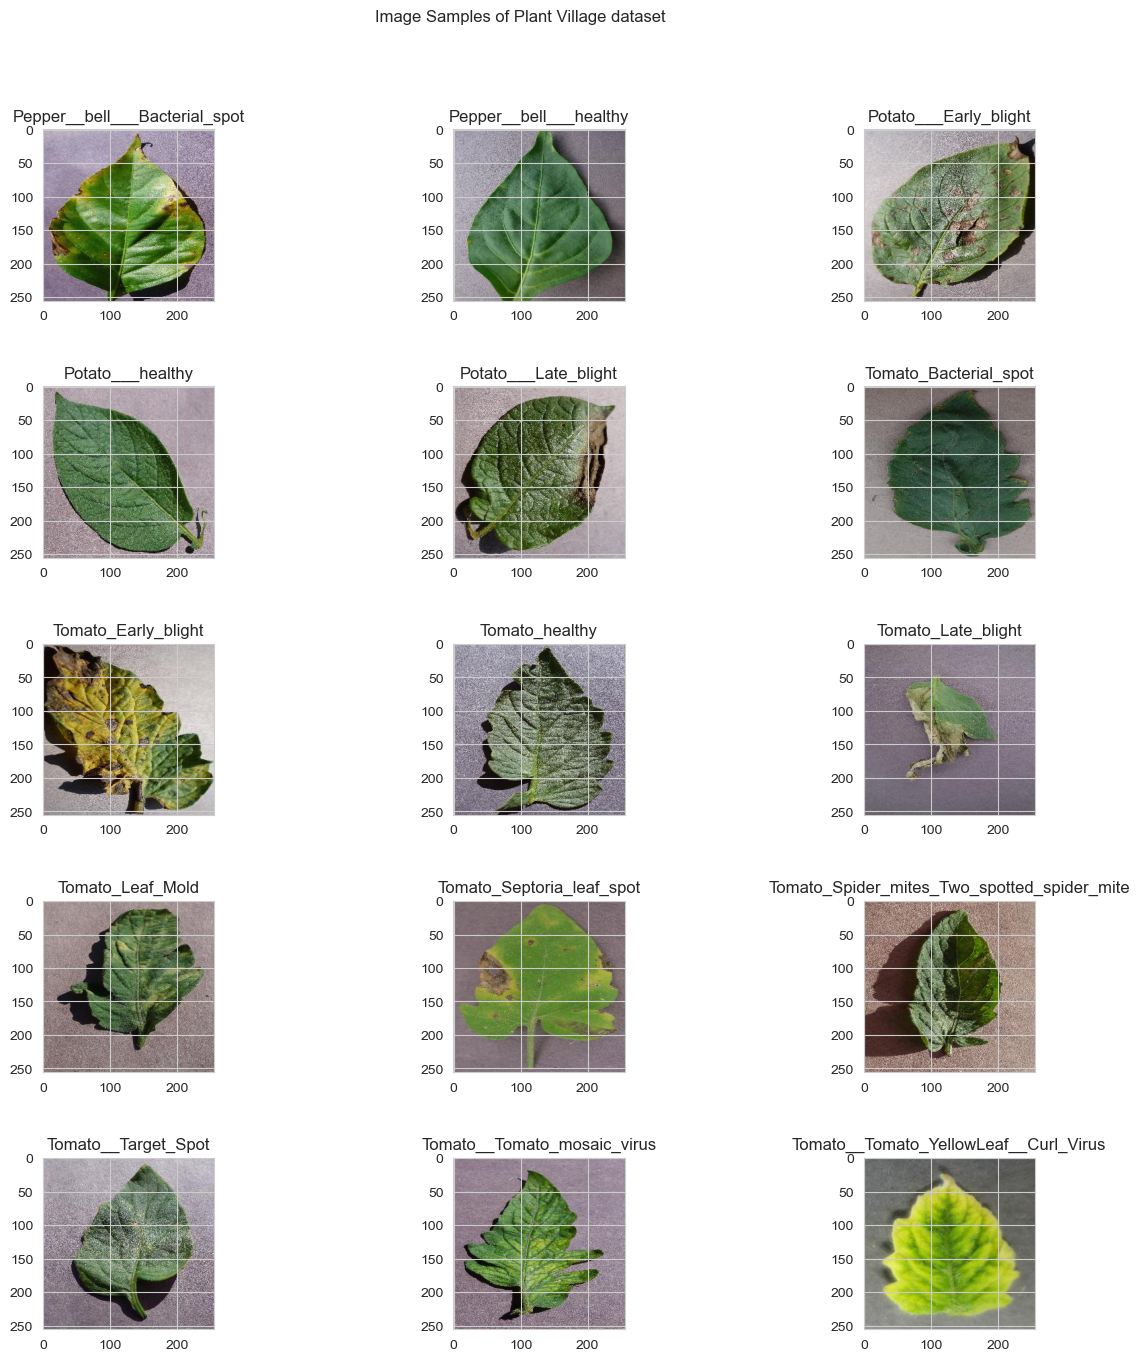

In [17]:
train.show_class_samples()

In [18]:
test = Dataset("dataset/test/")

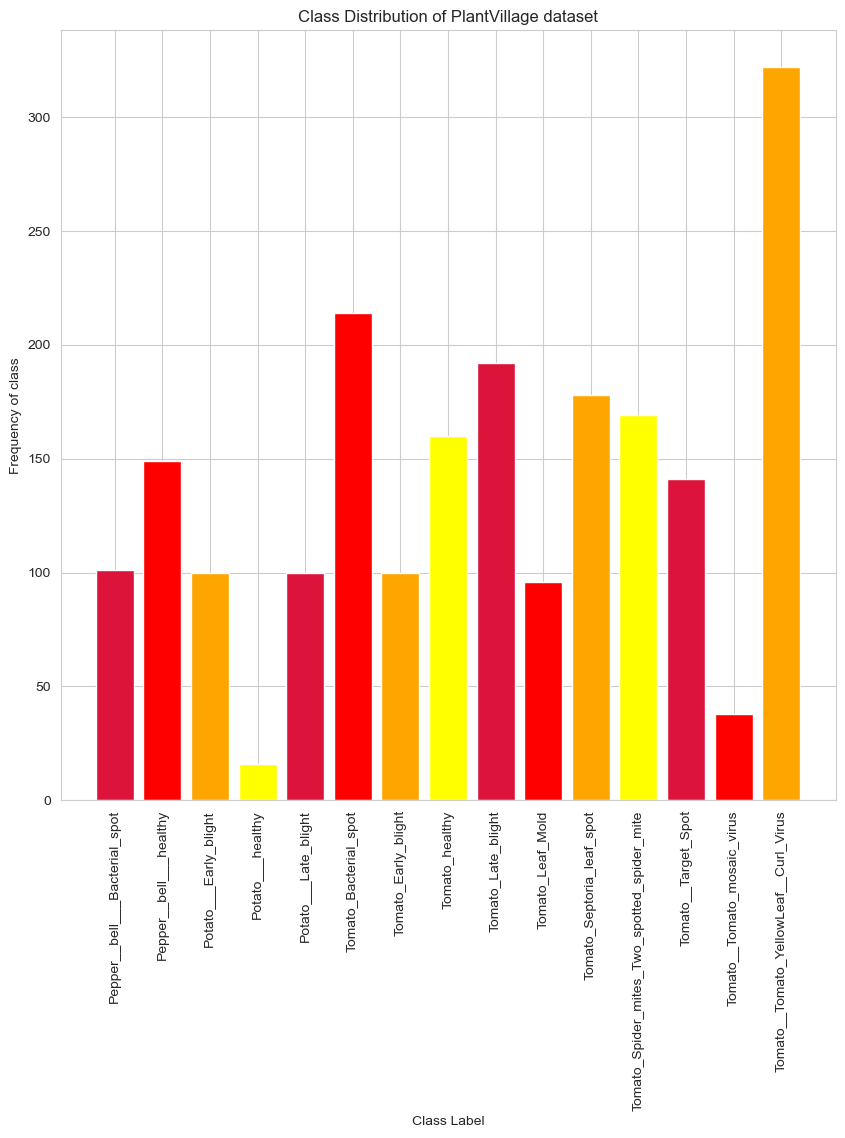

In [19]:
test.class_distributions()

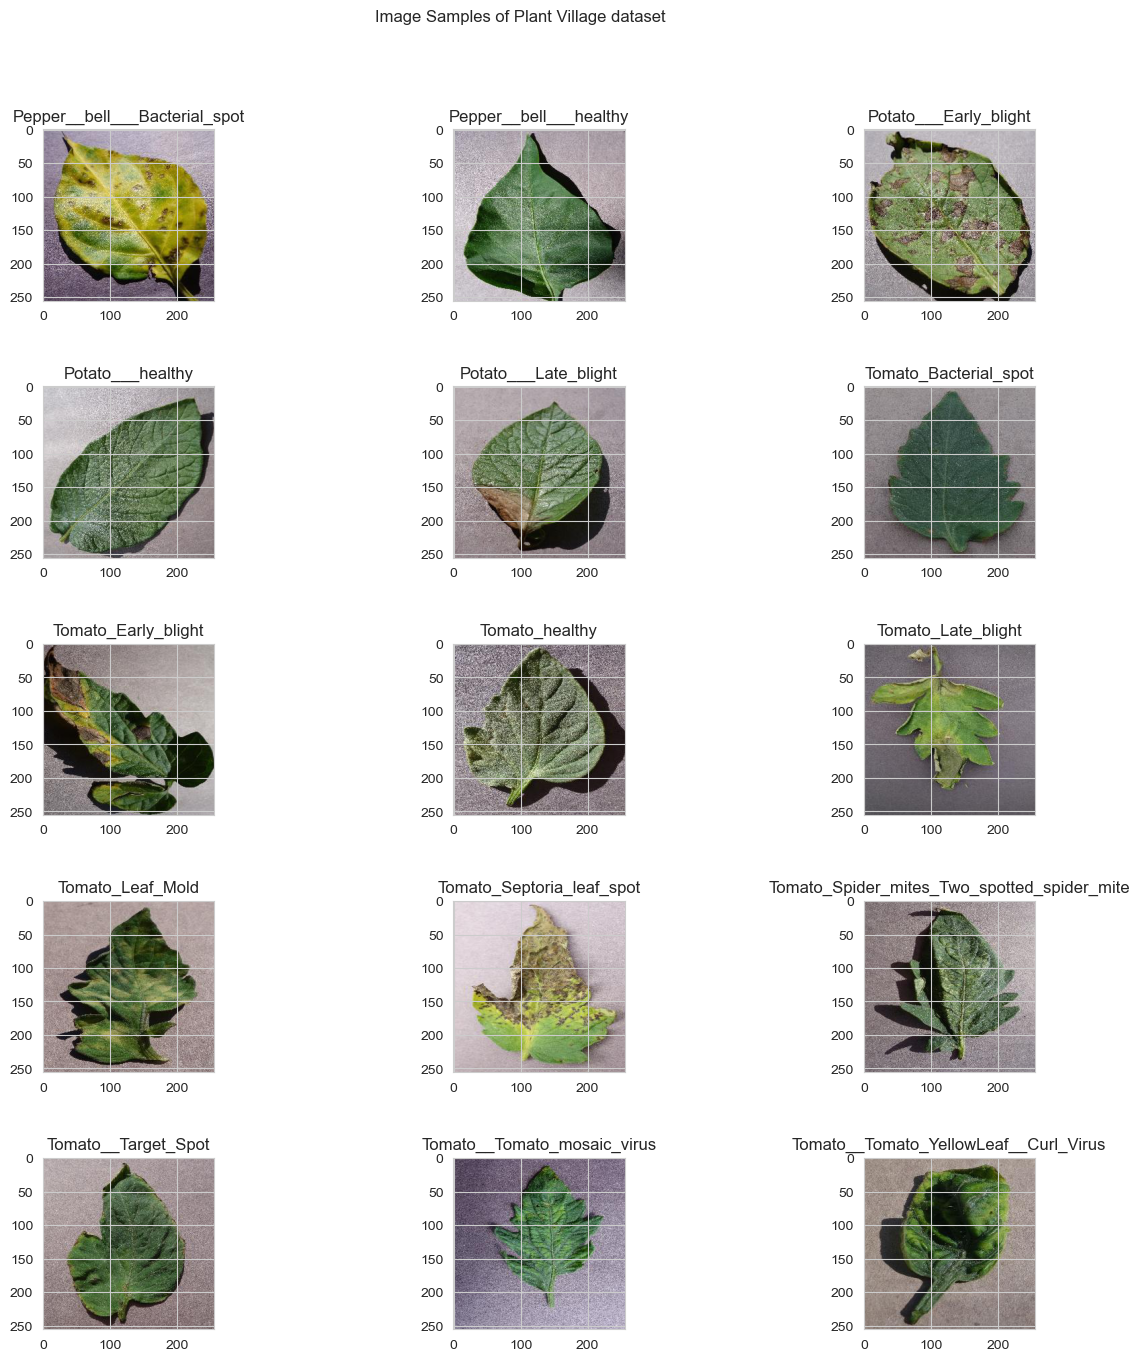

In [20]:
test.show_class_samples()

# Creating Data Generators

In [21]:
val = Dataset("dataset/val/")

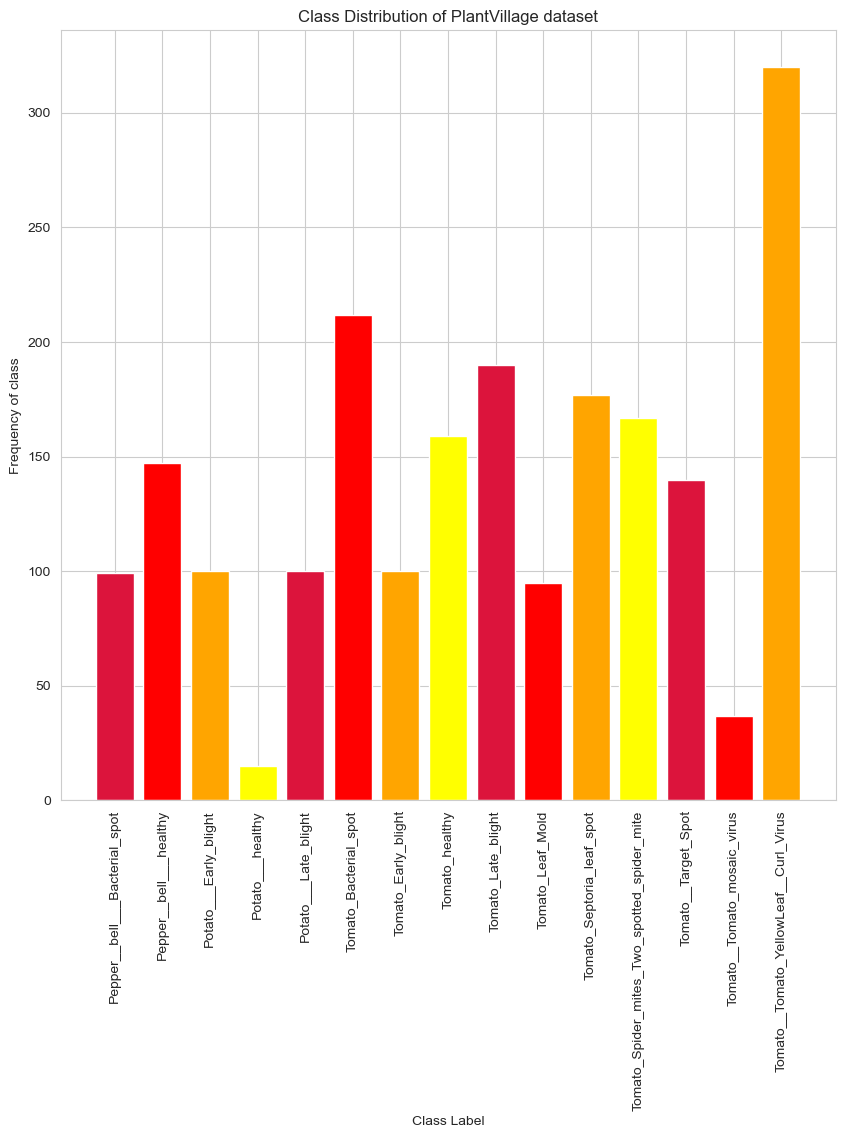

In [22]:
val.class_distributions()

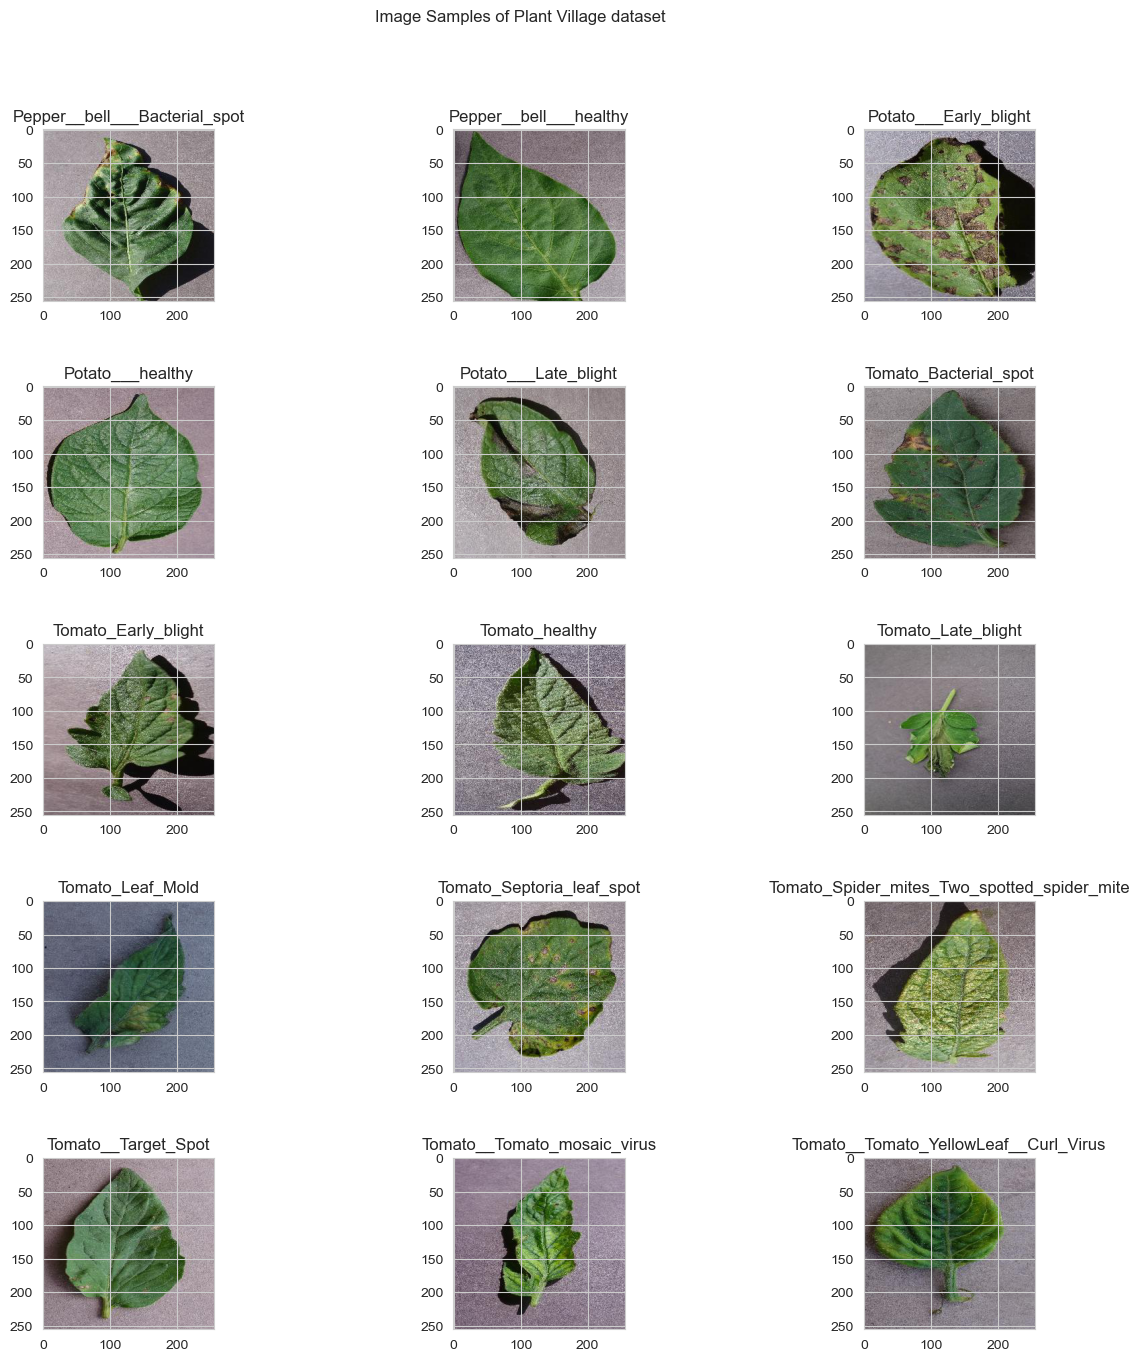

In [23]:
val.show_class_samples()

In [24]:
ds.create_generators()

In [25]:
train, val, test = ds.get_images()

Found 16504 images belonging to 15 classes.
Found 2058 images belonging to 15 classes.
Found 2076 images belonging to 15 classes.


# Implementing Transfer Learning

In [26]:
class TransferLearning:

    def __init__(self, train, val) -> None:
        self.train = train
        self.val = val
        self.model = None
        self.history = None

    def load_model(self):
        self.model = ResNet50(weights = 'imagenet', 
                              include_top = False, 
                              input_shape = (75,75,3))
    
    def mark_layers_non_trainable(self):
        for layer in self.model.layers:
            layer.trainable = False
    
    def add_final_layer(self):
        self.x = Flatten()(self.model.output)
        self.x = Dense(1000, activation='relu')(self.x)
        self.predictions = Dense(15, activation = 'softmax')(self.x)

    def compile_model(self):
        self.model = Model(inputs = self.model.input, outputs = self.predictions)
        self.model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])
    
    def train_model(self):
        self.history = self.model.fit(train,
                                      batch_size=32, 
                                      epochs=10, validation_data=val)
    
    def plot_history(self):
        fig, axs = plt.subplots(2, 1, figsize=(15,15))
        axs[0].plot(self.history.history['loss'])
        axs[0].plot(self.history.history['val_loss'])
        axs[0].title.set_text('Training Loss vs Validation Loss')
        axs[0].set_xlabel('Epochs')
        axs[0].set_ylabel('Loss')
        axs[0].legend(['Train','Val'])

        axs[1].plot(self.history.history['accuracy'])
        axs[1].plot(self.history.history['val_accuracy'])
        axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
        axs[1].set_xlabel('Epochs')
        axs[1].set_ylabel('Accuracy')
        axs[1].legend(['Train', 'Val'])


# Using Resnet50

In [27]:
tl = TransferLearning(train=train, val=val)

In [30]:
tl.load_model()

A local file was found, but it seems to be incomplete or outdated because the auto file hash does not match the original value of 4d473c1dd8becc155b73f8504c6f6626 so we will re-download the data.
94765736/94765736 [==============================] - 2120s 22us/step


In [31]:
tl.mark_layers_non_trainable()

In [32]:
tl.add_final_layer()

In [33]:
tl.compile_model()

In [34]:
tl.train_model()

Epoch 1/10
516/516 [==============================] - 538s 1s/step - loss: 1.5009 - accuracy: 0.8005 - val_loss: 0.3760 - val_accuracy: 0.8659
Epoch 2/10
516/516 [==============================] - 454s 881ms/step - loss: 0.2059 - accuracy: 0.9300 - val_loss: 0.3672 - val_accuracy: 0.8873
Epoch 3/10
516/516 [==============================] - 442s 856ms/step - loss: 0.1294 - accuracy: 0.9563 - val_loss: 0.3634 - val_accuracy: 0.9009
Epoch 4/10
516/516 [==============================] - 419s 813ms/step - loss: 0.1202 - accuracy: 0.9616 - val_loss: 0.5029 - val_accuracy: 0.8751
Epoch 5/10
516/516 [==============================] - 420s 815ms/step - loss: 0.0959 - accuracy: 0.9682 - val_loss: 0.3931 - val_accuracy: 0.9043
Epoch 6/10
516/516 [==============================] - 420s 813ms/step - loss: 0.1039 - accuracy: 0.9679 - val_loss: 0.4921 - val_accuracy: 0.9067
Epoch 7/10
516/516 [==============================] - 417s 808ms/step - loss: 0.1111 - accuracy: 0.9670 - val_loss: 0.4482 - va

In [35]:
tl.model.save("models/first_model")

INFO:tensorflow:Assets written to: models/first_model\assets


INFO:tensorflow:Assets written to: models/first_model\assets


In [36]:
CLASS_NAMES = list(train.class_indices.keys())
CLASS_NAMES


['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [37]:
from sklearn.metrics import accuracy_score, classification_report

In [38]:
predictions = np.argmax(tl.model.predict(test), axis=1)

65/65 [==============================] - 87s 1s/step


Test Accuracy: 93.160%


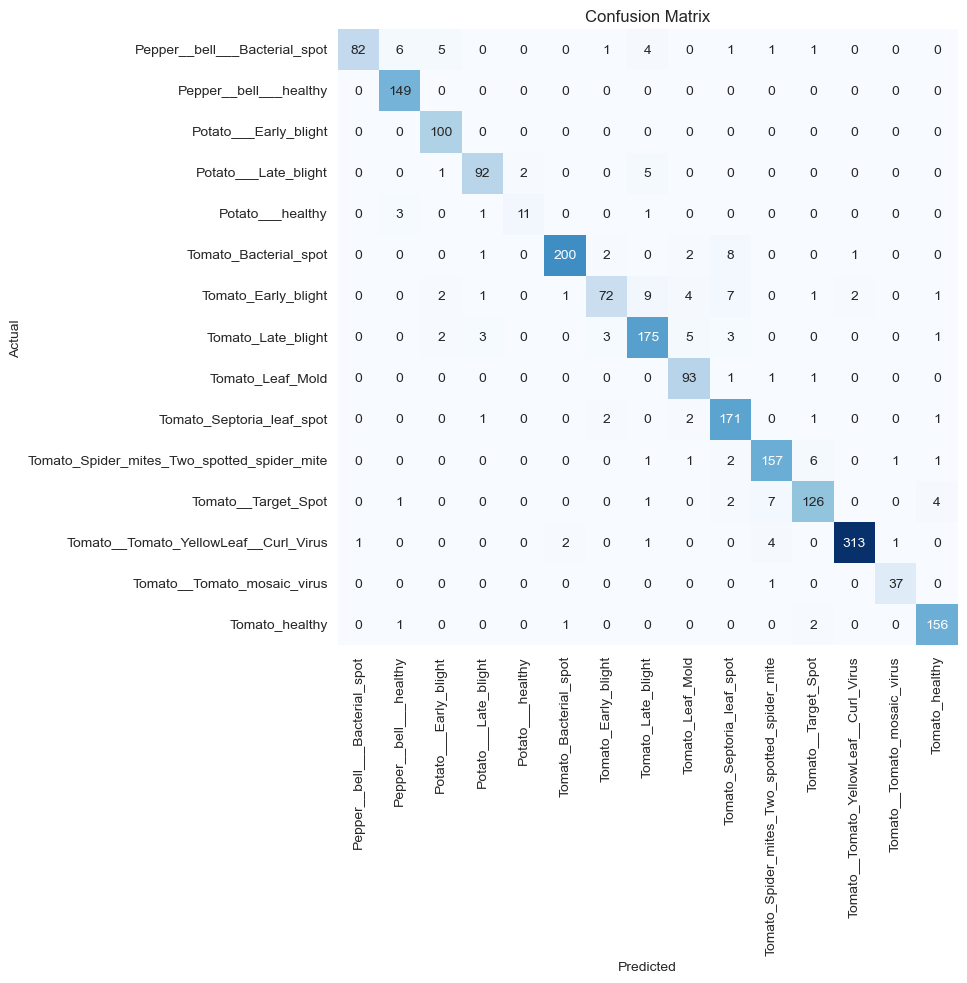

In [39]:
acc = accuracy_score(test.labels, predictions)
cm = tf.math.confusion_matrix(test.labels, predictions)
clr = classification_report(test.labels, predictions, target_names=CLASS_NAMES)

print("Test Accuracy: {:.3f}%".format(acc * 100))

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks= np.arange(15) + 0.5, labels=CLASS_NAMES, rotation=90)
plt.yticks(ticks= np.arange(15) + 0.5, labels=CLASS_NAMES, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [40]:
print(clr)

                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.99      0.81      0.89       101
                     Pepper__bell___healthy       0.93      1.00      0.96       149
                      Potato___Early_blight       0.91      1.00      0.95       100
                       Potato___Late_blight       0.93      0.92      0.92       100
                           Potato___healthy       0.85      0.69      0.76        16
                      Tomato_Bacterial_spot       0.98      0.93      0.96       214
                        Tomato_Early_blight       0.90      0.72      0.80       100
                         Tomato_Late_blight       0.89      0.91      0.90       192
                           Tomato_Leaf_Mold       0.87      0.97      0.92        96
                  Tomato_Septoria_leaf_spot       0.88      0.96      0.92       178
Tomato_Spider_mites_Two_spotted_spider_mite       0.92      0.93

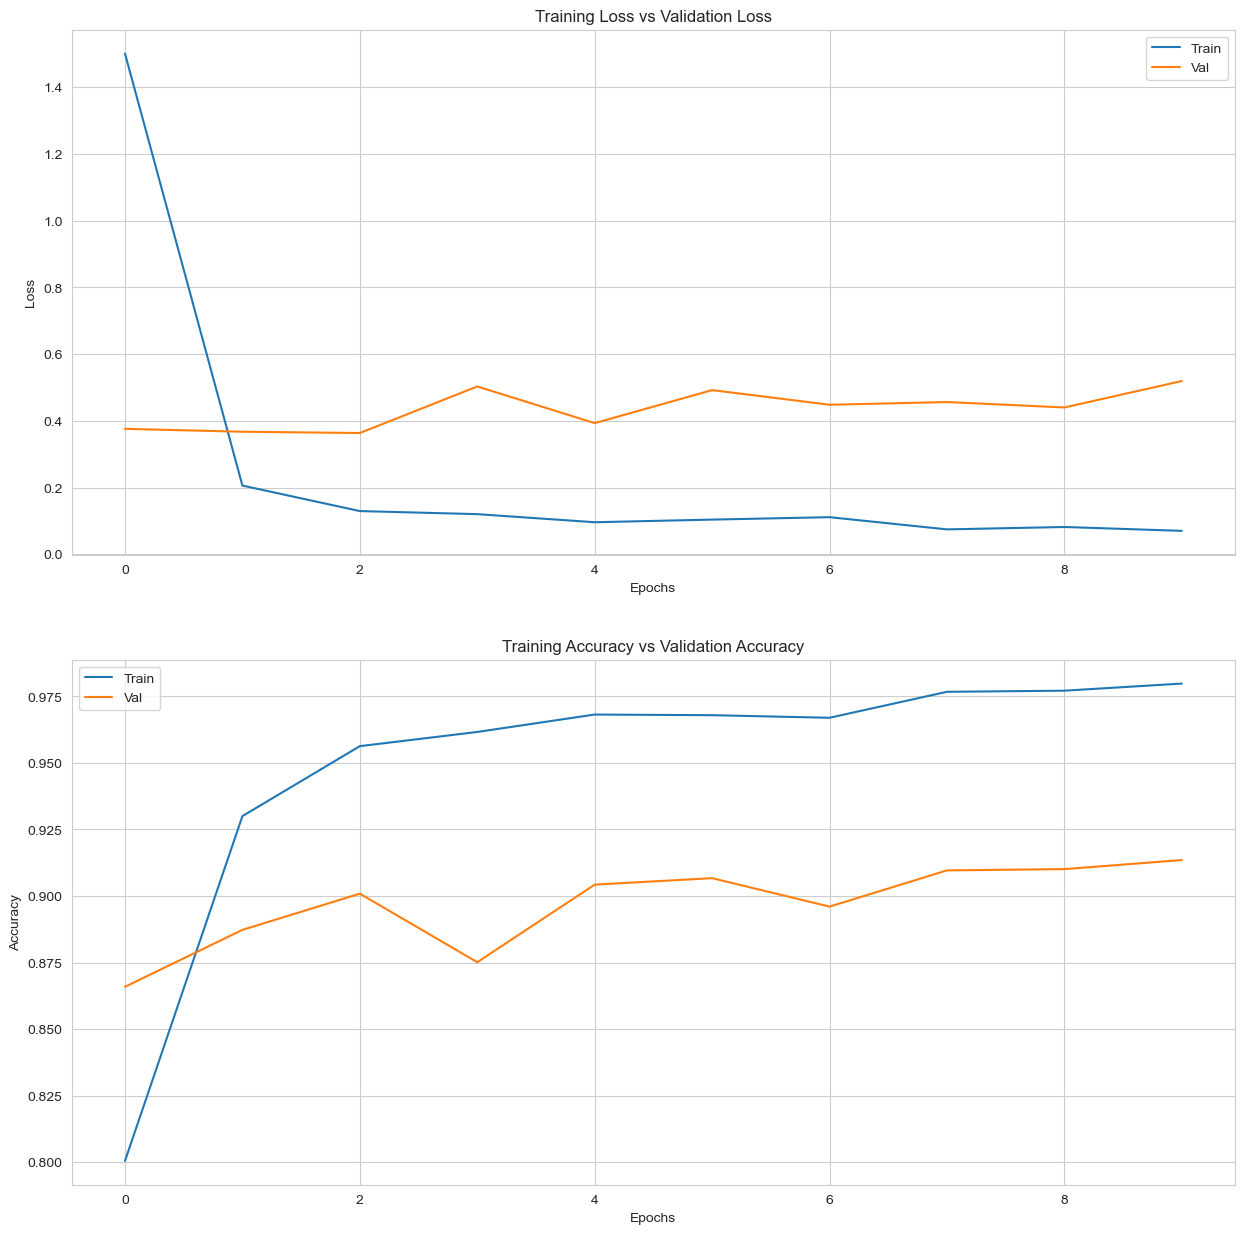

In [41]:
tl.plot_history()

## FineTuning

In [42]:
class FineTuning:

    def __init__(self, train, val) -> None:
        self.train = train
        self.val = val
        self.model = None
        self.history = None
        self.fine_tune_from = 100

    def load_model(self):
        self.model = ResNet50(weights = 'imagenet', 
                              include_top = False, 
                              input_shape = (75,75,3))
    
    def fine_tune(self):
        for layer in self.model.layers[:self.fine_tune_from]:
            layer.trainable = False

        for layer in self.model.layers[self.fine_tune_from:]:
            layer.trainable = True
    
    def add_final_layer(self):
        self.x = Flatten()(self.model.output)
        self.x = Dense(1000, activation='relu')(self.x)
        self.predictions = Dense(15, activation = 'softmax')(self.x)

    def compile_model(self):
        self.model = Model(inputs = self.model.input, outputs = self.predictions)
        self.model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])
    
    def train_model(self):
        self.history = self.model.fit(train,
                                      batch_size=32, 
                                      epochs=5, 
                                      validation_data=val,
                                      callbacks=[
                                        tf.keras.callbacks.EarlyStopping(
                                            monitor='val_loss',
                                            patience=3,
                                            restore_best_weights=True
                                        )
                                     ])
    
    def plot_history(self):
        fig, axs = plt.subplots(2, 1, figsize=(15,15))
        axs[0].plot(self.history.history['loss'])
        axs[0].plot(self.history.history['val_loss'])
        axs[0].title.set_text('Training Loss vs Validation Loss')
        axs[0].set_xlabel('Epochs')
        axs[0].set_ylabel('Loss')
        axs[0].legend(['Train','Val'])

        axs[1].plot(self.history.history['accuracy'])
        axs[1].plot(self.history.history['val_accuracy'])
        axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
        axs[1].set_xlabel('Epochs')
        axs[1].set_ylabel('Accuracy')
        axs[1].legend(['Train', 'Val'])

In [43]:
ft = FineTuning(train,val)

In [44]:
ft.load_model()

In [45]:
ft.fine_tune()

In [46]:
ft.add_final_layer()

In [47]:
ft.compile_model()

In [48]:
ft.train_model()

Epoch 1/5
516/516 [==============================] - 4186s 8s/step - loss: 0.6411 - accuracy: 0.8531 - val_loss: 0.4012 - val_accuracy: 0.9155
Epoch 2/5
516/516 [==============================] - 2599s 5s/step - loss: 0.1641 - accuracy: 0.9533 - val_loss: 0.2092 - val_accuracy: 0.9397
Epoch 3/5
516/516 [==============================] - 2673s 5s/step - loss: 0.1125 - accuracy: 0.9684 - val_loss: 0.1821 - val_accuracy: 0.9451
Epoch 4/5
516/516 [==============================] - 2667s 5s/step - loss: 0.0703 - accuracy: 0.9804 - val_loss: 0.1672 - val_accuracy: 0.9572
Epoch 5/5
516/516 [==============================] - 2617s 5s/step - loss: 0.0569 - accuracy: 0.9832 - val_loss: 0.1598 - val_accuracy: 0.9606


In [49]:
ft.model.save("models/second_model")

INFO:tensorflow:Assets written to: models/second_model\assets


INFO:tensorflow:Assets written to: models/second_model\assets


In [50]:
predictions = np.argmax(ft.model.predict(test), axis=1)

65/65 [==============================] - 216s 3s/step


Test Accuracy: 96.291%


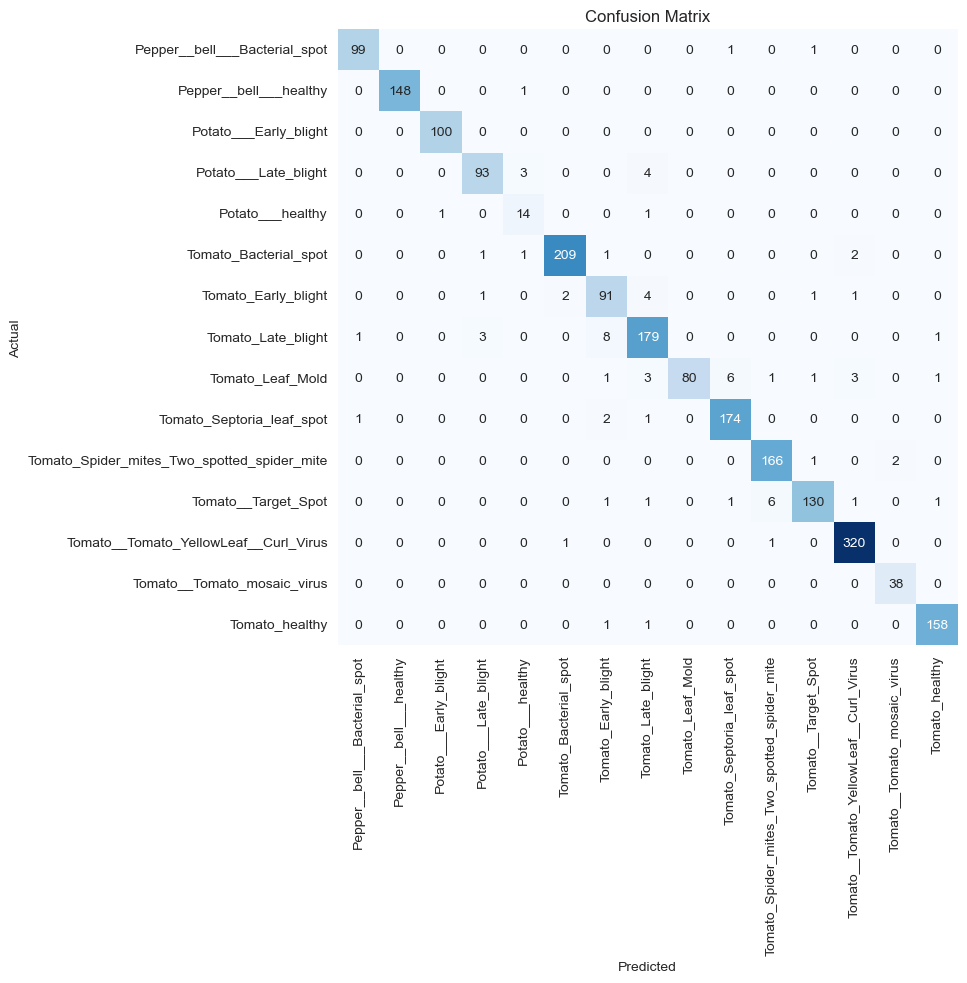

In [51]:
acc = accuracy_score(test.labels, predictions)
cm = tf.math.confusion_matrix(test.labels, predictions)
clr = classification_report(test.labels, predictions, target_names=CLASS_NAMES)

print("Test Accuracy: {:.3f}%".format(acc * 100))

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks= np.arange(15) + 0.5, labels=CLASS_NAMES, rotation=90)
plt.yticks(ticks= np.arange(15) + 0.5, labels=CLASS_NAMES, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [52]:
print(clr)

                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.98      0.98      0.98       101
                     Pepper__bell___healthy       1.00      0.99      1.00       149
                      Potato___Early_blight       0.99      1.00      1.00       100
                       Potato___Late_blight       0.95      0.93      0.94       100
                           Potato___healthy       0.74      0.88      0.80        16
                      Tomato_Bacterial_spot       0.99      0.98      0.98       214
                        Tomato_Early_blight       0.87      0.91      0.89       100
                         Tomato_Late_blight       0.92      0.93      0.93       192
                           Tomato_Leaf_Mold       1.00      0.83      0.91        96
                  Tomato_Septoria_leaf_spot       0.96      0.98      0.97       178
Tomato_Spider_mites_Two_spotted_spider_mite       0.95      0.98

In [53]:
ft.model.evaluate(test)

65/65 [==============================] - 247s 4s/step - loss: 0.1503 - accuracy: 0.9629


[0.15029770135879517, 0.962909460067749]

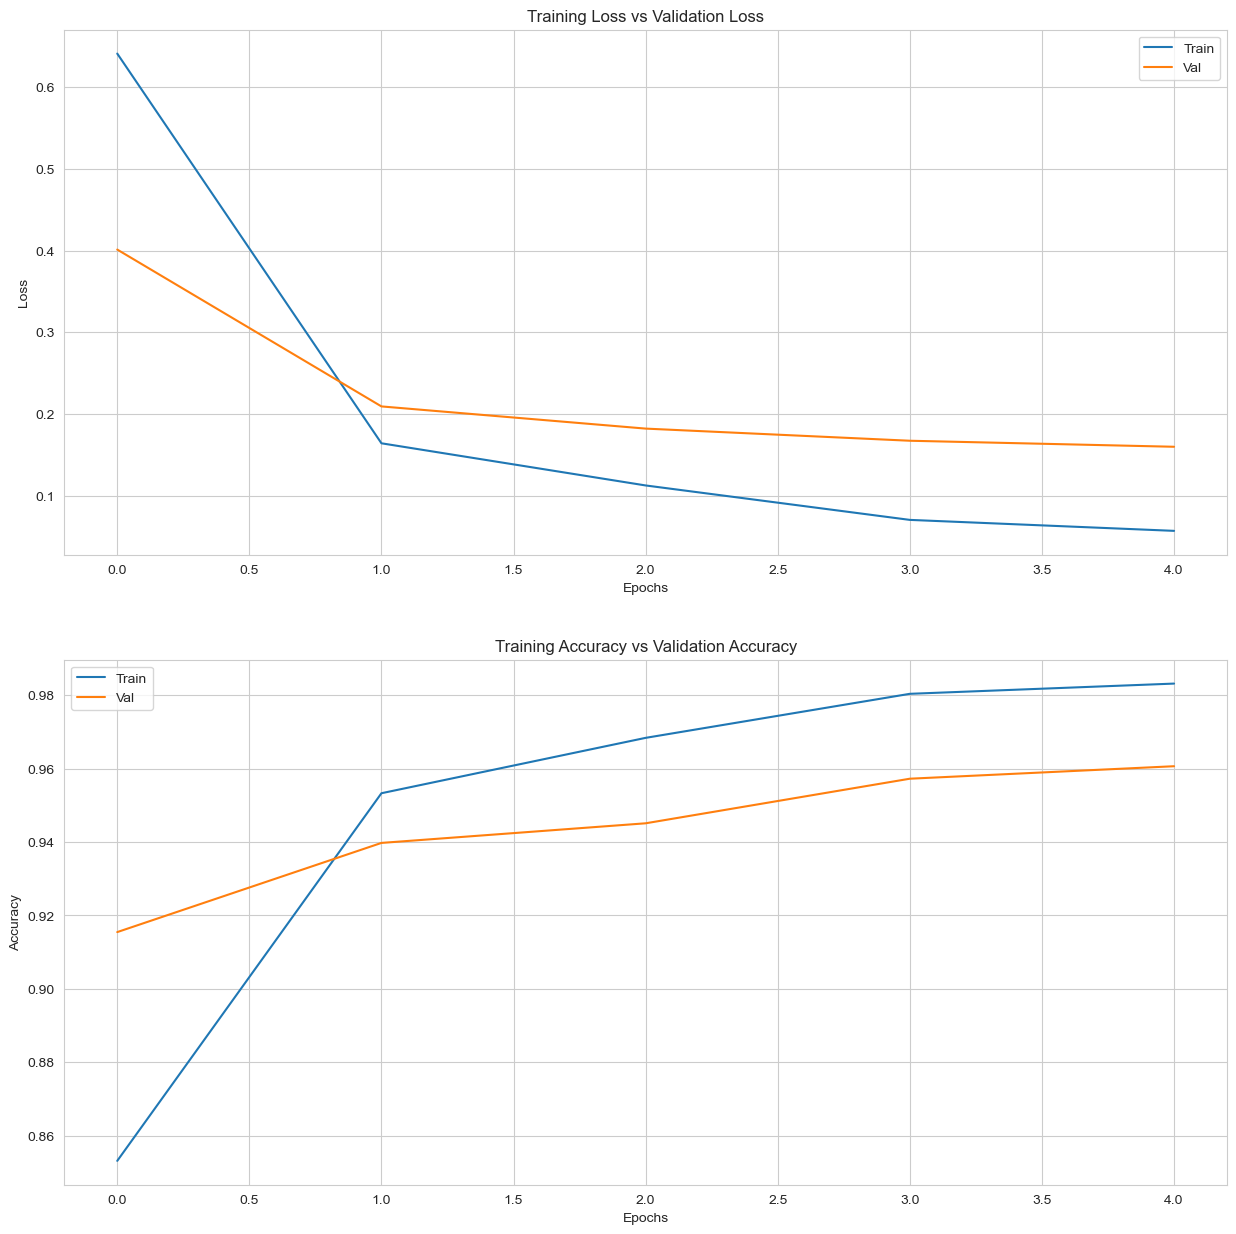

In [54]:
ft.plot_history()